In [1]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
tracks= utils.load('fma_metadata/tracks.csv')

In [4]:
tracks[tracks['set','subset']=='small'].index

Int64Index([     2,      5,     10,    140,    141,    148,    182,    190,
               193,    194,
            ...
            153956, 154303, 154305, 154306, 154307, 154308, 154309, 154413,
            154414, 155066],
           dtype='int64', name='track_id', length=8000)

In [5]:
df= pd.read_csv('fma_metadata/ts_dataset_Fede.csv', index_col='track_id')

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,647,648,649,650,651,652,653,654,655,656
track_id,,,,,,,,,,,,,,,,,,,,,
2,1753.560229,2257.466861,2882.222974,2670.961118,2111.101477,2032.723377,2203.948417,2010.167976,2087.718374,2048.793779,...,2490.791964,2108.328245,2279.144320,2483.595672,2485.493595,2283.669119,1909.055744,1286.629299,1225.566106,1242.179012
5,1063.952553,1073.580479,929.287077,935.735381,1423.752755,1706.984032,1727.663239,1250.945719,1086.371810,1345.396506,...,1784.380570,1655.845934,1542.638447,1329.698678,1609.129768,1637.752364,1723.875319,1843.045431,1947.498431,1830.323977
148,854.195714,929.899905,1074.438149,1106.270403,1262.605776,1260.138068,1284.212077,1428.672989,1632.183927,1771.411672,...,1613.198016,1604.099335,1616.798575,1580.397821,1552.878064,1551.043023,1559.632696,1575.169382,1581.174697,1512.527248
182,1935.067371,1944.322028,2033.296617,2056.287808,1980.944183,1920.720428,2093.844116,2219.083104,2259.879382,2154.652270,...,1659.613066,1765.649337,1972.606639,2059.421914,1950.256330,1769.939838,1802.032154,1858.346644,1845.767989,1873.613617
255,1058.040165,1030.117320,1019.887341,994.122747,971.307168,982.655750,1015.293813,919.057637,876.318176,734.271712,...,909.310526,787.699413,786.786420,966.045405,1120.767451,1099.290394,1054.891137,995.573291,871.263998,740.037442


In [7]:
genre= tracks[[('track', 'genre_top')]]

In [8]:
genre.columns= genre.columns.droplevel(0)

In [9]:
df= df.join(genre)

In [10]:
df['genre_top'].value_counts()

Electronic             999
Experimental           999
Rock                   999
Hip-Hop                997
Blues                    0
Classical                0
Country                  0
Easy Listening           0
Folk                     0
Instrumental             0
International            0
Jazz                     0
Old-Time / Historic      0
Pop                      0
Soul-RnB                 0
Spoken                   0
Name: genre_top, dtype: int64

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,647,648,649,650,651,652,653,654,655,656
count,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,...,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000,3994.000000
mean,1304.075947,1352.370243,1391.096193,1394.039413,1395.704929,1397.309872,1401.805997,1399.040898,1397.210897,1394.757308,...,1409.816406,1407.060158,1407.841361,1408.331980,1407.215280,1407.609869,1406.419867,1399.377531,1398.990116,1404.103612
std,541.134264,536.369890,536.956155,535.189624,532.915739,532.533308,534.305658,537.718622,543.486847,542.020595,...,541.308730,540.306882,543.537878,544.666943,545.597572,551.828087,551.536363,549.569987,528.357394,501.147884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,911.830547,976.425761,1022.576391,1019.838703,1019.462452,1022.625475,1016.918783,1021.281246,1022.184112,1015.562465,...,1026.465947,1016.603676,1017.254390,1022.377325,1017.293525,1014.748532,1016.926485,1007.332400,1015.465253,1046.225633
50%,1273.946925,1338.355548,1378.426165,1377.989745,1380.087193,1389.011331,1393.168822,1386.416039,1387.621809,1399.502829,...,1404.193088,1399.290729,1406.032551,1404.337371,1398.180653,1399.175449,1404.565670,1395.634196,1380.343266,1367.389611
75%,1663.551256,1705.830409,1739.756751,1753.821145,1755.619213,1746.308823,1751.457183,1744.286552,1743.536502,1737.809315,...,1761.502165,1762.393595,1752.793698,1750.484229,1760.966162,1769.621757,1761.025486,1759.942211,1731.674159,1708.778714
max,3999.691442,3932.304646,3975.453221,3835.070405,3515.377129,3401.722822,3483.062288,3884.104515,3703.724175,4089.562276,...,4115.623947,4036.812563,4058.967404,3930.952360,3818.211354,3704.855516,4022.943220,3785.097025,3992.754284,4167.533675


In [12]:
attr=[]
for col in df.columns:
    if(col!='genre_top'):
        attr.append(col)  

In [13]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
df[attr] = scaler.fit_transform(df[attr].values).squeeze()

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,648,649,650,651,652,653,654,655,656,genre_top
track_id,,,,,,,,,,,,,,,,,,,,,
2,-0.134461,1.091443,2.611349,2.097392,0.735365,0.544687,0.961243,0.489815,0.678479,0.583783,...,0.728619,1.144180,1.641569,1.646186,1.155188,0.243829,-1.270410,-1.418964,-1.378548,Hip-Hop
5,-0.915597,-0.890180,-1.271114,-1.254090,0.034274,0.782003,0.836597,-0.421936,-0.856411,-0.172586,...,0.646999,0.348132,-0.214028,0.523669,0.599232,0.826596,1.141205,1.416961,1.107621,Hip-Hop
148,-1.398620,-1.179364,-0.760749,-0.668556,-0.215774,-0.222921,-0.153197,0.265194,0.854607,1.257842,...,0.773268,0.810048,0.704623,0.624920,0.619605,0.644483,0.689480,0.706873,0.508055,Experimental
182,0.831877,0.867620,1.211251,1.300045,1.009059,0.776468,1.445092,1.928781,2.086341,1.679941,...,0.177564,0.976858,1.312150,0.890539,0.194135,0.318079,0.535572,0.486992,0.594535,Rock
255,-0.001086,-0.109745,-0.149553,-0.249814,-0.338598,-0.294437,-0.167429,-0.541922,-0.708239,-1.260999,...,-1.053090,-1.056643,-0.359074,0.243012,0.159436,-0.013340,-0.244169,-0.727907,-1.238562,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154306,-1.110754,-1.006785,-0.815322,-0.789090,-0.743797,-0.657886,-0.834670,-1.228586,-1.459256,-1.172778,...,-1.080429,1.155361,1.460806,-0.275518,0.091648,0.024073,-0.617410,-1.290487,-1.266442,Hip-Hop
154307,-0.476355,-0.345470,0.423441,0.826796,0.759305,0.680591,0.419693,0.143946,-0.250479,-0.323848,...,-1.031161,-0.967002,-0.190268,-0.372293,-0.532872,-0.863057,-1.194852,-1.370949,-1.208573,Hip-Hop
154308,-1.461760,-1.352874,-0.667393,0.180564,-0.043601,-0.641125,-0.769813,-0.651408,1.364934,2.620067,...,1.187887,0.431956,-0.469773,-0.895047,-0.669839,-0.516315,-0.603362,-0.740841,-0.866379,Hip-Hop


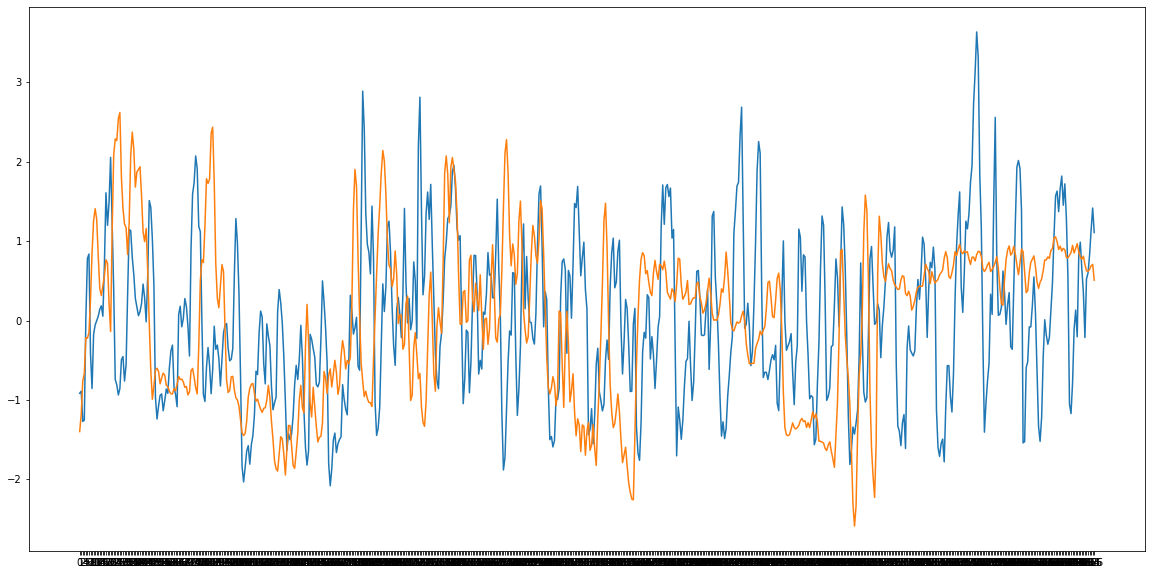

In [15]:
plt.plot(df.loc[5][0:657])
plt.plot(df.loc[148][0:657])
plt.show()

In [16]:
ts1=df.loc[2][0:657]
ts2=df.loc[5][0:657]
ts3=df.loc[148][0:657]

In [17]:
print(cityblock(ts1,ts2))

753.682103656232


In [18]:
print(cityblock(ts1,ts3))

769.7701856331857


In [19]:
print(dtw(ts1,ts2))

14.617743684111995


In [20]:
print(dtw(ts1,ts3))

16.187596418481515


## Approximation

In [21]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [22]:
sax= SymbolicAggregateApproximation(n_segments=50, alphabet_size_avg=8)

In [23]:
X_sax= sax.fit_transform(df[attr].values).squeeze()
X_sax.shape

C:\Users\polpo\anaconda3\envs\fma\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3994 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(3994, 50)

In [24]:
X_sax[0]

array([5, 3, 4, 4, 5, 5, 3, 5, 5, 2, 6, 2, 3, 3, 5, 5, 3, 1, 3, 5, 4, 3,
       3, 6, 3, 2, 3, 2, 4, 3, 3, 4, 4, 3, 3, 4, 5, 3, 3, 2, 1, 2, 0, 1,
       5, 3, 5, 2, 1, 7])

C:\Users\polpo\anaconda3\envs\fma\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


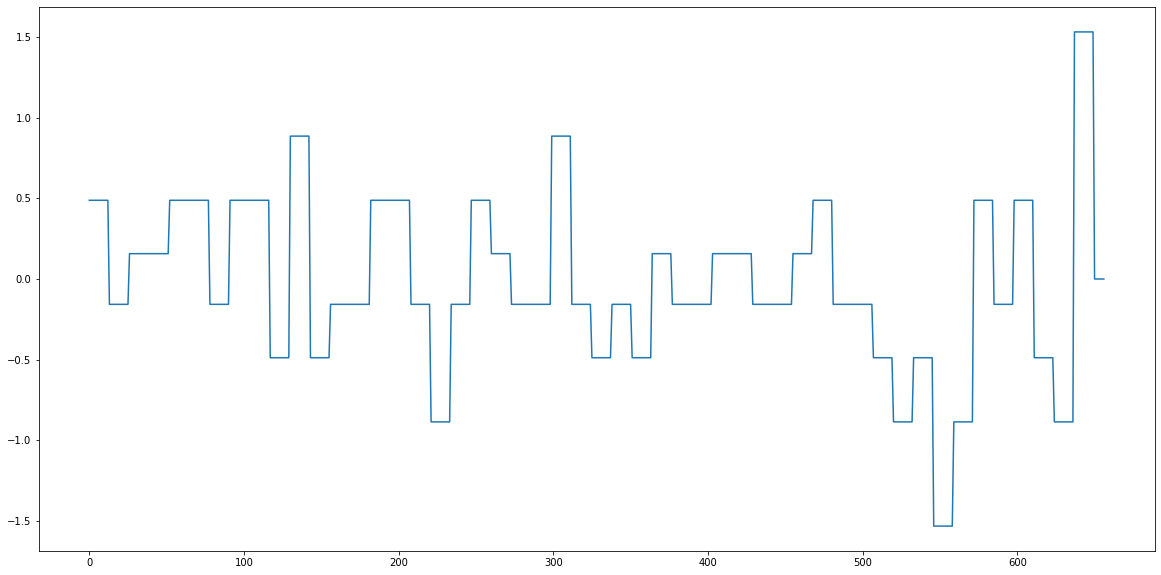

In [25]:
plt.plot(sax.inverse_transform(X_sax[0].reshape(1,-1)).ravel())
plt.show()

## Clustering

In [316]:
X= df[attr].values
y= df['genre_top']

In [317]:
kmeans= TimeSeriesKMeans(n_clusters=4, metric='euclidean')

In [318]:
kmeans.fit(X)

TimeSeriesKMeans(n_clusters=4)

In [319]:
kmeans.labels_

array([3, 3, 1, ..., 0, 3, 1], dtype=int64)

In [321]:
silhouette_score(X, kmeans.labels_, metric='euclidean')

0.016916285627256684

In [341]:
# find best k
sil=[]
for k in range(2,15):
    kmeans= TimeSeriesKMeans(n_clusters=k, metric='euclidean')
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))

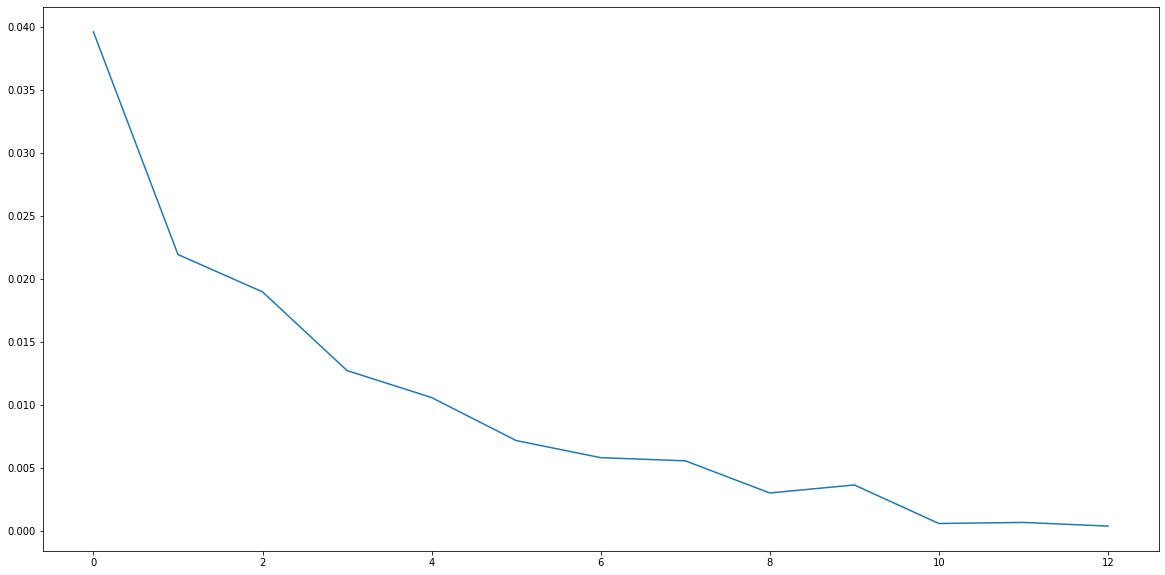

In [342]:
plt.plot(sil)
plt.show()

In [30]:
%%time
inertia=[]
for k in range(2,15):
    kmeans= TimeSeriesKMeans(n_clusters=k, metric='dtw', n_jobs=-1,
                         metric_params={'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 10})
    kmeans.fit(X_sax)
    inertia.append(kmeans.inertia_)
    print('%d cluster: %.2f',k, kmeans.inertia_)

%d cluster: %.2f 2 56.71508850734566
%d cluster: %.2f 3 54.473701348647154
%d cluster: %.2f 4 52.09905707643514
%d cluster: %.2f 5 49.65577583915534
%d cluster: %.2f 6 48.8454887321824
%d cluster: %.2f 7 47.923133742783946
%d cluster: %.2f 8 47.46524414315539
%d cluster: %.2f 9 47.009705078333916
%d cluster: %.2f 10 46.04591541470582
%d cluster: %.2f 11 45.481394493217714
%d cluster: %.2f 12 45.41054154950292
%d cluster: %.2f 13 44.40339022876719
%d cluster: %.2f 14 44.389047969671566
Wall time: 1h 2min 48s


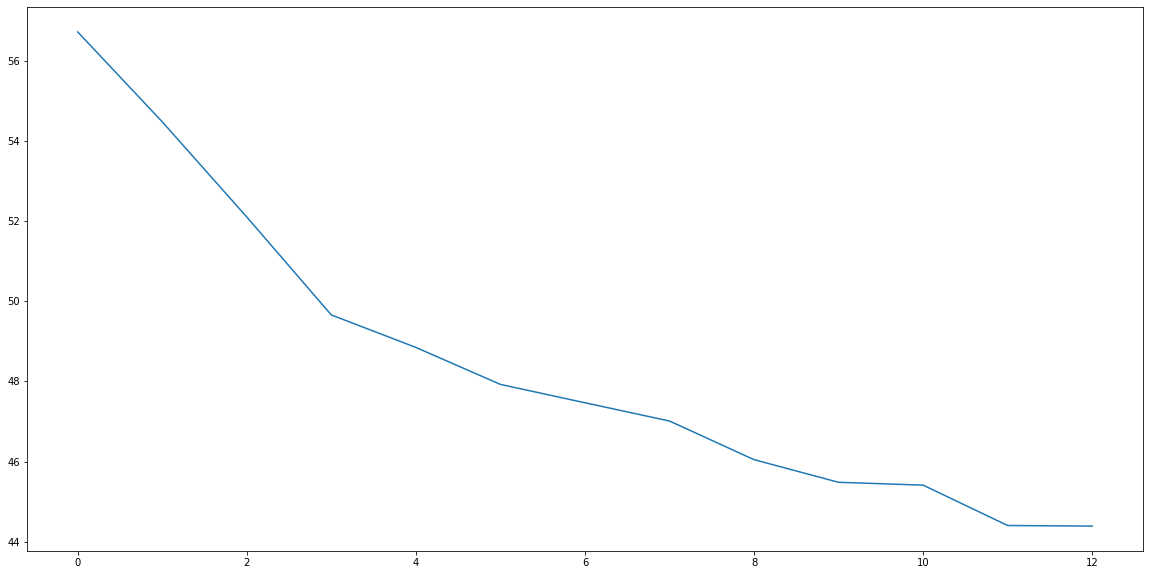

In [31]:
plt.plot(inertia)
plt.show()